Importation des library

In [2]:
import pandas as pd
import numpy as np
import vectorbt as vbt
import matplotlib.pyplot as plt
import anywidget
import os
plt.style.use('dark_background')

Chargement des données

In [3]:
# Télécharger les données (Utilise Python Binance)
# a PARTIR D'une date jusqu'a aujourd'hui (intervale 15 minutes)
symbol = ['ETHUSDT']
#day
time = "15m"
# Téléchargement des données
data = vbt.BinanceData.download(
    symbol, 
    start='2024-09-01', 
    interval=time
)

0it [00:00, ?it/s]

Mise en forme des données

In [4]:
# Agencement des données + index + mis à l'heure de paris
df_raw = data.get(['Close','Open','High','Low','Volume']).copy()
df_raw.index = df_raw.index.tz_convert('Europe/Paris')
df_raw.tail()

,Close,Open,High,Low,Volume
Open time,,,,,
2025-12-08 21:15:00+01:00,3126.92,3128.30,3135.20,3125.18,1611.8975
2025-12-08 21:30:00+01:00,3128.78,3126.93,3130.43,3121.36,1663.4270
2025-12-08 21:45:00+01:00,3135.91,3128.79,3145.47,3125.35,7502.9793
2025-12-08 22:00:00+01:00,3128.18,3135.90,3141.49,3127.14,2691.4015
2025-12-08 22:15:00+01:00,3128.60,3128.18,3129.08,3126.98,259.9195


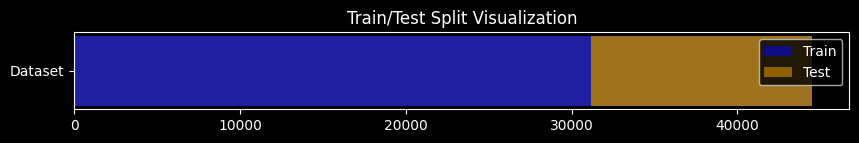

In [5]:
# Separation des données en train et test (IS/OOS) (70/30%)
split_idx = int(0.7*len(df_raw))
train_data = df_raw.iloc[:split_idx]
test_data = df_raw.iloc[split_idx:]

# Affichage de la séparation des données
plt.figure(figsize=(10, 1))
plt.barh(['Dataset'], [len(df_raw)], color='lightgray', alpha=0.3)
plt.barh(['Dataset'], [split_idx], color='blue', alpha=0.5, label='Train')
plt.barh(['Dataset'], [len(df_raw)-split_idx], left=split_idx, color='orange', alpha=0.5, label='Test')
plt.title('Train/Test Split Visualization')
plt.legend()
plt.show()

In [6]:
# Selection du train_set comme données d'entrainement
df = train_data.copy()

In [12]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import os

# Charger les données
# df = vos données OHLCV

# Stratégie SIMPLIFIÉE
for body_threshold in np.arange(0.001, 0.005, 0.0005):
    df_test = df.copy()
    
    # 1. Calcul du body
    df_test['body'] = (df_test['Close'] - df_test['Open']).abs() / df_test['Open']
    
    # 2. Identification des imbalances
    df_test['imbalance_up'] = (df_test['body'] > body_threshold) & (df_test['Close'] > df_test['Open'])
    df_test['imbalance_down'] = (df_test['body'] > body_threshold) & (df_test['Close'] < df_test['Open'])
    
    # 3. Prix des imbalances
    df_test['imbalance_high'] = np.where(df_test['imbalance_up'], df_test['High'], np.nan)
    df_test['imbalance_low'] = np.where(df_test['imbalance_down'], df_test['Low'], np.nan)
    
    # 4. Forward fill avec fenêtre limitée
    df_test['last_imbalance_high'] = df_test['imbalance_high'].fillna(method='ffill', limit=10)
    df_test['last_imbalance_low'] = df_test['imbalance_low'].fillna(method='ffill', limit=10)
    
    # 5. TENDANCE
    df_test['ema_20'] = df_test['Close'].ewm(span=20, adjust=False).mean()
    df_test['ema_50'] = df_test['Close'].ewm(span=50, adjust=False).mean()
    df_test['ema_200'] = df_test['Close'].ewm(span=200, adjust=False).mean()
    
    # RSI
    df_test['rsi'] = vbt.RSI.run(df_test['Close'], window=14).rsi
    
    # Volume moyen
    df_test['volume_ma'] = df_test['Volume'].rolling(20).mean()
    
    # 6. SIGNAUX SIMPLIFIÉS (sans référence circulaire)
    # Créer une colonne pour le cooldown
    df_test['last_signal'] = 0  # 0 = aucun signal, 1 = long, -1 = short
    
    # Initialiser les signaux
    df_test['long_signal'] = False
    df_test['short_signal'] = False
    
    # Logique de trading
    for i in range(1, len(df_test)):
        # Conditions LONG
        long_condition = (
            df_test['imbalance_up'].iloc[i-1] and
            df_test['Close'].iloc[i] > df_test['ema_20'].iloc[i] and
            df_test['Close'].iloc[i] > df_test['ema_50'].iloc[i] and
            df_test['ema_20'].iloc[i] > df_test['ema_50'].iloc[i] and
            df_test['ema_50'].iloc[i] > df_test['ema_200'].iloc[i] and
            40 < df_test['rsi'].iloc[i] < 70 and
            df_test['Volume'].iloc[i] > df_test['volume_ma'].iloc[i] * 0.8
        )
        
        # Conditions SHORT
        short_condition = (
            df_test['imbalance_down'].iloc[i-1] and
            df_test['Close'].iloc[i] < df_test['ema_20'].iloc[i] and
            df_test['Close'].iloc[i] < df_test['ema_50'].iloc[i] and
            df_test['ema_20'].iloc[i] < df_test['ema_50'].iloc[i] and
            df_test['ema_50'].iloc[i] < df_test['ema_200'].iloc[i] and
            30 < df_test['rsi'].iloc[i] < 60 and
            df_test['Volume'].iloc[i] > df_test['volume_ma'].iloc[i] * 0.8
        )
        
        # Vérifier le cooldown (pas de signal dans les 5 dernières bougies)
        cooldown_passed = True
        if i >= 5:
            recent_signals = df_test['last_signal'].iloc[i-5:i]
            cooldown_passed = not any(recent_signals != 0)
        
        # Appliquer les signaux
        if long_condition and cooldown_passed:
            df_test.loc[df_test.index[i], 'long_signal'] = True
            df_test.loc[df_test.index[i], 'last_signal'] = 1
        elif short_condition and cooldown_passed:
            df_test.loc[df_test.index[i], 'short_signal'] = True
            df_test.loc[df_test.index[i], 'last_signal'] = -1
        else:
            df_test.loc[df_test.index[i], 'last_signal'] = 0
    
    # 7. Backtest
    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['long_signal'],
        exits=df_test['short_signal'],
        init_cash=10000,
        fees=0.001,
        slippage=0.001,
        size=0.1,
        freq='15m'
    )
    
    # 8. Statistiques
    stats = portfolio.stats()
    
    result = {
        'body_threshold': body_threshold,
        'total_return': stats['Total Return [%]'],
        'sharpe': stats['Sharpe Ratio'],
        'max_dd': stats['Max Drawdown [%]'],
        'win_rate': stats['Win Rate [%]'],
        'profit_factor': stats['Profit Factor'],
        'total_trades': stats['Total Trades']
    }
    
    result_df = pd.DataFrame([result])
    result_df.to_csv('strategie_simple.csv', mode='a', 
                     header=not os.path.exists('strategie_simple.csv'), index=False)
    
    print(f"Threshold: {body_threshold:.4f} | Return: {result['total_return']:.2f}% | "
          f"Trades: {result['total_trades']}")

print("\nBacktest terminé!")

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:26: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Threshold: 0.0010 | Return: 0.73% | Trades: 70


C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:26: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Threshold: 0.0015 | Return: 0.68% | Trades: 67


C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:26: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Threshold: 0.0020 | Return: 0.62% | Trades: 65


C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:26: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Threshold: 0.0025 | Return: 0.33% | Trades: 62


C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:26: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Threshold: 0.0030 | Return: 0.52% | Trades: 54


C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:26: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Threshold: 0.0035 | Return: 0.04% | Trades: 53


C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:26: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Threshold: 0.0040 | Return: -0.20% | Trades: 51


C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:25: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\gunsa\AppData\Local\Temp\ipykernel_10304\181275208.py:26: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Threshold: 0.0045 | Return: -0.24% | Trades: 49

Backtest terminé!
